# BIGRU model met embeddings
## met embedding pre-training

In [1]:
from torch import optim
from data.dataloader import DatasetLoader, PretrainLoader
from torch.utils.data import DataLoader
import torch
from models.PreTrainEmbedding import PreTrainEmbedding
from torch import nn
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

## 1. Dataset uitlezen

In [2]:
removeapps = ["Screen on (locked)",
              "Screen off (locked)",
              "Screen on (unlocked)",
              "Screen off",
              "Samsung Experience Service",
              "Package installer",
              "System UI",
              "Customisation Service",
              "Configuration update",
              "EmergencyManagerService",
              "DeviceKeystring",
              "Samsung Keyboard",
              "HwModuleTest",
              "Device shutdown",
              "Device boot"]
pretraindataset = PretrainLoader("eventlog/phone_usage_cleaned.csv",
                                 nr_samples=2000, d=900, T=1200,
                                 removeapps=removeapps,
                                 nr_generated=100000)
pretrain_dataloader = DataLoader(pretraindataset, batch_size=128)

## 2. Embedding pre-train

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrainembedding = PreTrainEmbedding(max_apps=pretraindataset.nr_apps,
                                      src_dim=4)
pretrainembedding.to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrainembedding.parameters(), lr=0.0015)
epochs = 100
running_loss = 0.0
total = 0
correct = 0
for j in range(epochs):
    for prev_app_index, next_app_index in pretrain_dataloader:
        prev_app_index, next_app_index = prev_app_index.to(device=device), next_app_index.to(device=device)

        optimizer.zero_grad()
        outputs = pretrainembedding(prev_app_index)
        loss = criterion(outputs[0], next_app_index)
        loss.backward()
        optimizer.step()

        total += 128
        arg_maxs = torch.argmax(outputs, dim=2)  # collapse cols
        num_correct = torch.sum(next_app_index==arg_maxs).item()
        correct += num_correct

        running_loss += loss.item()
    if j%20==0:
        print('loss: %.3f' %
                  (running_loss / 2000))
        running_loss = 0.0
        print('Accuracy of the network is: ' + str(100 * correct / total))
        total = 0
        correct = 0

loss: 1.481
Accuracy of the network is: 8.913443094629155
loss: 22.516
Accuracy of the network is: 14.940257352941176
loss: 21.546
Accuracy of the network is: 15.919916879795396
loss: 21.292
Accuracy of the network is: 16.185511908567776
loss: 21.157
Accuracy of the network is: 16.374230738491047


## 3. Embedding evaluation

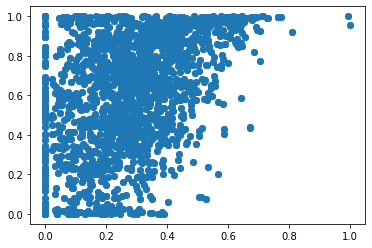

In [4]:
from matplotlib.pyplot import scatter
from scipy.special import softmax

embeddings = pretrainembedding.src_embedding.weight.detach().cpu().numpy()
graphvertices = pretraindataset.graph
embeddingsimilarity = []
verticessimilarity = []

embeddings = softmax(embeddings, axis=1)

# 62*62-62
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        if i!=j:
            embeddingsimilarity.append(cosine_similarity(embeddings[i:i+1], embeddings[j:j+1])[0][0])
            verticessimilarity.append(cosine_similarity(graphvertices[i:i+1], graphvertices[j:j+1])[0][0])

scatter(verticessimilarity, embeddingsimilarity)

In [5]:
def mean(someList):
    total = 0
    for a in someList:
        total += float(a)
    mean = total/len(someList)
    return mean
def standDev(someList):
    listMean = mean(someList)
    dev = 0.0
    for i in range(len(someList)):
        dev += (someList[i]-listMean)**2
    dev = dev**(1/2.0)
    return dev
def correlCo(someList1, someList2):

    # First establish the means and standard deviations for both lists.
    xMean = mean(someList1)
    yMean = mean(someList2)
    xStandDev = standDev(someList1)
    yStandDev = standDev(someList2)
    # r numerator
    rNum = 0.0
    for i in range(len(someList1)):
        rNum += (someList1[i]-xMean)*(someList2[i]-yMean)

    # r denominator
    rDen = xStandDev * yStandDev

    r =  rNum/rDen
    return r

print(correlCo(embeddingsimilarity, verticessimilarity))
# 0.4124 0.40612 0.4199 16
# 0.4486 10
# 0.4694 9
# 0.5154 0.4744 8
# 0.5010 0.4957 7
# 0.5348 0.4970 0.5473 0.5078 6
# 0.5029 0.4200 0.4570 5
# 0.4865 0.4166 0.5554 4


0.41893173172159837
